# 作業 : (Kaggle)鐵達尼生存預測

# [教學目標]
- 以下用鐵達尼預測資料, 展示如何使用葉編碼, 並觀察預測效果
- 因為只有分類問題比較適合葉編碼, 因此範例與作業都使用鐵達尼的資料(二元分類問題)

# [教學目標]
- 了解葉編碼的寫作方式 : 使用梯度提升樹 (In[3]~In[6], Out[3]~Out[6])
- 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[7]~In[9], Out[7]~Out[9])

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

data_path = '../data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5) #將train_X 其中50% 來當test_X (不重複)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5) #再將train_X 其中50% 來當test_X (不重複)

#假設 train_X 共有891筆資料 拿891*0.5=446(無條件進位)當test_X  891-446=445當train_X
#再將445 裡面的裡面的50%當val_X  445*0.5(無條件進位) = 223  445-223 = 222當train_X
print(f'df shape: {df.shape}')
print(f'train_X shape: {train_X.shape}')
print(f'test_X shape: {test_X.shape}')
print(f'val_X shape: {val_X.shape}')

df shape: (891, 10)
train_X shape: (222, 10)
test_X shape: (446, 10)
val_X shape: (223, 10)


### GradientBoostingClassifier
- subsample 從資料的採樣比例
- n_estimators 迭代次數 太小容易Underfit 太大容易Overfit
- min_samples_split 當樣本數量少於10%時就停止劃分
- min_samples_leaf 要成為一個子葉至少需要30%的樣本 樣本太少就會向上聚集
- max_features 劃分時最多考慮的特徵數
- max_depth 最大深度
- learning_rate 學習率


### LogisticRegression
- solver優化演算法
- max_iter最大迭代次數

### 先利用GradientBoostingClassifier調整參數(train_set)
### 再將其特徵分枝結果拿來做OneHotEncoder(train_set) 
### 最後將Encode的結果特徵拿來做LogisticRegression分類(valid_set)

In [4]:
# 梯度提升樹調整參數並擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
# 調整參數的方式採用 RandomSearchCV 或 GridSearchCV, 以後的進度會再教給大家, 本次先直接使用調參結果
gdbt = GradientBoostingClassifier(subsample=0.93, n_estimators=320, min_samples_split=0.1, min_samples_leaf=0.3, 
                                  max_features=4, max_depth=4, learning_rate=0.16)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

gdbt.fit(train_X, train_Y)
onehot.fit(gdbt.apply(train_X)[:, :, 0])
lr.fit(onehot.transform(gdbt.apply(val_X)[:, :, 0]), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
gdbt.apply(train_X).shape

(222, 320, 1)

In [6]:
gdbt.apply(train_X)[:, :, 0]

array([[2., 2., 2., ..., 3., 1., 0.],
       [1., 1., 1., ..., 3., 2., 0.],
       [1., 1., 1., ..., 2., 2., 0.],
       ...,
       [2., 2., 2., ..., 2., 1., 0.],
       [2., 1., 1., ..., 4., 2., 0.],
       [2., 2., 2., ..., 3., 1., 0.]])

### LogisticRegression & GradientBoostingClassifier    predict_proba(X(樣本,特徵)) 
### return回來的值(樣本,類別(是與否))
### roc_curve(label標籤, 分數機率值) return fpr, tpr, thresholds

In [7]:
# 將梯度提升樹+葉編碼+邏輯斯迴歸結果輸出
pred_gdbt_lr = lr.predict_proba(onehot.transform(gdbt.apply(test_X)[:, :, 0]))[:, 1]
fpr_gdbt_lr, tpr_gdbt_lr, _ = roc_curve(test_Y, pred_gdbt_lr)
# 將梯度提升樹結果輸出
pred_gdbt = gdbt.predict_proba(test_X)[:, 1]
fpr_gdbt, tpr_gdbt, _ = roc_curve(test_Y, pred_gdbt)

In [8]:
lr.predict_proba(onehot.transform(gdbt.apply(test_X)[:, :, 0])).shape

(446, 2)

### ROC圖
- x軸為FPR(偽陽率) 判斷有,但實際上沒有
- y軸為TPR(真陽率) 判斷有,且實際上有
- 愈靠近左上角,準確率愈高
- 取線下的面積稱為AUC 愈大準確度愈高
- 當AUC=1時 取線會呈現九十度 經過最左上角的點
- 當AUC在0.5~1之間(斜線上半部),表示優於隨機猜測
- AUC=0.5時曲線與斜線貼合,表示跟隨機猜測一樣(丟銅板)
- AUC<0.5比隨機猜測還差,但如果反預測將優於隨機猜測

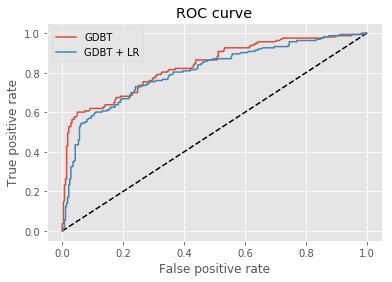

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gdbt, tpr_gdbt, label='GDBT')
plt.plot(fpr_gdbt_lr, tpr_gdbt_lr, label='GDBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[10], Out[10])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

### RandomForestClassifier
- bootstrap 樣本是否隨機抽樣且抽到後還會丟回箱子中,讓其他樹有機會再次抽中

In [10]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

"""
Your Code Here (Hint : 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同)
"""

rf.fit(train_X, train_Y)
onehot.fit(rf.apply(train_X))
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
rf.apply(train_X).shape

(222, 20)

In [12]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
"""
Your Code Here 
"""
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:,1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)

# 將隨機森林結果輸出
"""
Your Code Here 
"""
pred_rf = rf.predict_proba(test_X)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

In [13]:
lr.predict_proba(onehot.transform(rf.apply(test_X))).shape

(446, 2)

In [14]:
rf.predict_proba(test_X).shape

(446, 2)

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?


**Your answer:** *是,葉編碼有稍微提高預測正確性,真陽性(True Positive Rate)較高*

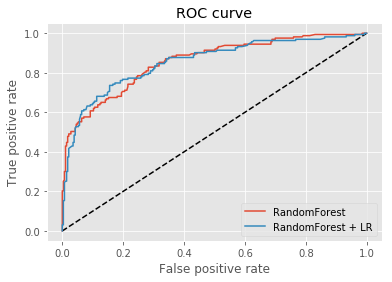

In [15]:
# 將結果繪圖
"""
Your Code Here 
"""

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RandomForest')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RandomForest + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()